In [1]:
import re, argparse, sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm.auto import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_scheduler

import os, json, transformers

In [2]:
dataset = load_dataset('cnn_dailymail', '3.0.0')

modelname = 'distilbert/distilgpt2'
gpt2_tokenizer = transformers.GPT2Tokenizer.from_pretrained(modelname, eos_token=None, bos_token=None, pad_token='<pad>', unk_token='<unk>', add_prefix_space=False)
gpt2_model = GPT2LMHeadModel.from_pretrained(modelname)

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
model = gpt2_model
tokenizer = gpt2_tokenizer
# tokenizer.pad_token = tokenizer.eos_token

In [4]:
with open(os.path.join('/workspace/Thought2Text/semantic-decoding/data_lm/', 'perceived', "vocab.json"), "r") as f:
    gpt_vocab = json.load(f)

tokenizer.add_tokens(gpt_vocab)

14437

In [14]:
tokenizer.save_pretrained('gpt2_tokenizer')

('gpt2_tokenizer/tokenizer_config.json',
 'gpt2_tokenizer/special_tokens_map.json',
 'gpt2_tokenizer/vocab.json',
 'gpt2_tokenizer/merges.txt',
 'gpt2_tokenizer/added_tokens.json')

In [6]:
model.resize_token_embeddings(len(tokenizer))

Embedding(64696, 768)

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [8]:
class cnnDataSet(Dataset):
    def __init__(self, data):
        self.data = data
        self.id = self.data['id']
        self.article = self.data['article']
        self.highlights = self.data['highlights']
        self.input_ids = torch.tensor(self.data['input_ids'])
        self.attention_mask = torch.tensor(self.data['attention_mask'])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx],  self.attention_mask[idx], torch.sum(self.attention_mask[idx])

class HyperParameters():
    def __init__(self, batch_sz=3, learn_rate = 1e-5, wt_decay = 1e-5, num_epochs = 2):
        self.batch_size = batch_sz
        self.num_epochs = num_epochs
        self.learn_rate = learn_rate
        self.wt_decay = wt_decay
        pass

    def get_hyperparam(self):
        """
        Method to return the hyper-parameters of training the model in this order:\\
        batch_size, learn_rate, weight_decay, num_epochs
        """
        return self.batch_size, self.learn_rate, self.wt_decay, self.num_epochs

def split_article(art):
    splitstr = re.split(' -- ', art, 1)
    # print(splitstr)
    if len(splitstr) == 1 or (re.search(r'(\([\w+]+\))|([A-Z][A-Z]+)|(\([\w\s]+\))|(\([\w]+\.[\w]+\))', splitstr[0])) is None:
        return art
    else:
        return splitstr[1]

    
def tokenize_str(examples):
    # inputs = [doc for doc in examples["article"]]
    inputs = []
    # labs = examples['highlights']
    
    inputs = [split_article(art) for art in examples['article']]

    # model_inputs = gpt2_tokenizer(inputs, max_length=1024, truncation=True)
    # labels = gpt2_tokenizer(text_target=labs, max_length=128, truncation=True)

    model_inputs = tokenizer(inputs, max_length=1024, truncation=True, return_tensors='pt', padding='max_length')
    # labels = tokenizer(text_target=labs, max_length=128, truncation=True)

    # model_inputs["labels"] = labels["input_ids"]
    return model_inputs


def train_model(train_dataset, plot_loss_curves=True, model=gpt2_model, hyperparams=HyperParameters()):
    '''
    Method to fine tune and train the passed model
    Returns nothing
    train_dataset - The datset whose text is in the format PASSAGE\nQUESTION?ANSWER
    '''

    # train_dataset = GPT2CustomDataset(training_text, training_labels, gpt2_tokenizer)
    # unique_labels = train_dataset.get_unique_labels()
    # unique_labels_encoding = {lab:gpt2_tokenizer.encode(lab)[0] for lab in unique_labels}
    # Hyperparameters
    batch_sz, learn_rate,  wt_decay, num_epochs, = hyperparams.get_hyperparam()

    train_dataloader = DataLoader(train_dataset, batch_size=batch_sz)

    # torch.set_default_device(device)
    
    # model.to(dtype=torch.float16)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learn_rate, weight_decay=wt_decay)
    # lossfunc = binary_cross_entropy_with_logits().to(device)
    # print(model.parameters())
    dataloader_len = len(train_dataloader)
    num_training_steps = num_epochs * dataloader_len
    
    lr_scheduler = get_scheduler(
        name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
    )
    
    progress_bar = tqdm(range(num_training_steps))
    loss_list = []

    # Use FP16 for speed purposes
    scaler = torch.cuda.amp.GradScaler()
    # Update loss and other values every 3 iterations
    accum_iter = 3
    
    torch.cuda.empty_cache()
    model.train()
    for epoch in range(num_epochs):
        
        epoch_loss = []
        for  batch_idx, batch in enumerate(train_dataloader):
            with torch.set_grad_enabled(True):


                max_valid_input, max_valid_attention = trunc_batch(batch)
                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == dataloader_len):                    
                    optimizer.zero_grad()

                with torch.cuda.amp.autocast():
                    
                    output = model(
                                   input_ids = max_valid_input.to(device),
                                   attention_mask=max_valid_attention.to(device),
                                   labels=max_valid_input.to(device)
                                   )
                    loss = output.loss/accum_iter
                
                # loss.backward()
                scaler.scale(loss).backward()
                # model.float()
                if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == dataloader_len):
                    # optimizer.step()
                    scaler.step(optimizer)
                    # scaler.step(lr_scheduler)
                    # optimizer.zero_grad()
                    scaler.update()
                    lr_scheduler.step()
            
            progress_bar.update(1)
            if plot_loss_curves:
                loss_list.append(loss.item())
                
    if plot_loss_curves:
        plot_loss_curve(loss_list, f'distil-gpt2 LM LR : {learn_rate}')


def trunc_batch(batch):
    max_pad = torch.max(batch[2])
    # What we do here is that for all tensor in the batch, we truncate the attention and padding to the length of the 
    # maximum valid length, so save time and memory on computing the softmaxes
    input_ids = torch.stack([b[:max_pad] for b in batch[0]])
    attention_masks = torch.stack([b[:max_pad] for b in batch[1]])

    return input_ids, attention_masks

def plot_loss_curve(losslist, rword, save_title = 'loss_curve_a2_p2.png'):
    l = len(losslist)
    plt.plot(range(l), losslist)
    plt.title(f'Plotting the loss across Iterations for "{rword}" ')    
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    # plt.show()
    plt.savefig(save_title)


def main(hyperparams):
    # Just training the first 10k articles for now
    train = dataset['train'].select(range(10000))
    test = dataset['test'].select(range(1000))
    validation = dataset['validation']
    tokenized_train = train.map(tokenize_str, batched=True)
    tokenized_test = test.map(tokenize_str, batched=True)

    tokenized_train_dataset = cnnDataSet(tokenized_train)
    train_model(tokenized_train_dataset, plot_loss_curves=True, model=model, hyperparams=hyperparams)
    
    # https://pytorch.org/tutorials/beginner/saving_loading_models.html
    torch.save(model, 'fineTunedDistilGPT2_cnnDaily')

def initParser():
    parser = argparse.ArgumentParser(
        prog='gpt2/train_distilgpt2_cnnDaily.py',
        description='Python script to train distilbert/gpt2 on CNN-Daily-News dataset'
        )
    base_hpm = HyperParameters()
    batch_sz, learn_rate,  wt_decay, epochs, = base_hpm.get_hyperparam()
    parser.add_argument('-b', '--batch-size', dest='batchsz', action='store', 
                        nargs='?',default=batch_sz, type=int, help=f'Batch Size. Default Value : {batch_sz}')
    parser.add_argument('-l', '--learn-rate', dest='lrnrate', action='store', 
                        nargs='?',default=learn_rate, type=float, help=f'Learning Rate. Default Value : {learn_rate}')
    parser.add_argument('-w', '--weight-decay', dest='wtdecay', action='store', 
                        nargs='?',default=wt_decay, type=float, help=f'Weight Decay. Default Value : {wt_decay}')
    parser.add_argument('-e', '--epochs', dest='epochs', action='store', 
                        nargs='?',default=epochs, type=int, help=f'Num Epochs. Default Value : {epochs}')
        
    return parser

In [9]:
parser = initParser()
args = parser.parse_args("-b 8 -l 5e-7 -w 1e-2 -e 2".split())
args_hyperparams = HyperParameters(
    batch_sz=args.batchsz,
    learn_rate=args.lrnrate,
    wt_decay=args.wtdecay,
    num_epochs=args.epochs)

# print(type(args.batchsz), type(args.epochs))
# print(args_hyperparams.get_hyperparam())
# main(args_hyperparams)

In [10]:
# Just training the first 10k articles for now
train = dataset['train'].select(range(20000))
test = dataset['test'].select(range(2000))
validation = dataset['validation']
tokenized_train = train.map(tokenize_str, batched=True)
tokenized_test = test.map(tokenize_str, batched=True)

tokenized_train_dataset = cnnDataSet(tokenized_train)

Map:   0%|          | 0/20000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


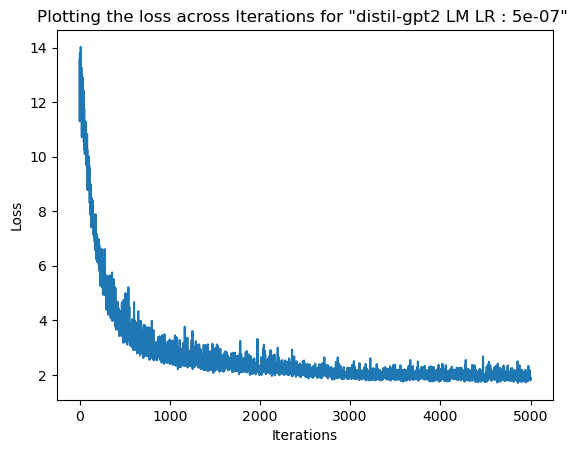

In [11]:
train_model(tokenized_train_dataset, plot_loss_curves=True, model=model, hyperparams=args_hyperparams)

In [33]:
for k,v in gpt2_tokenizer.vocab.items():
    if v == id.item():
        print(k)

AttributeError: 'builtin_function_or_method' object has no attribute 'item'

In [13]:
model.save_pretrained('gpt2_finetuned')

In [21]:
import transformers

In [23]:
gpt2 = transformers.AutoModelForCausalLM.from_pretrained('gpt2_pretrained')

In [30]:
gpt2.eval()
with torch.no_grad():
    out = gpt2(**tokenizer('what to do in life? to', return_tensors='pt'))

In [1]:
torch.argmax(out.logits[:,-1])

NameError: name 'torch' is not defined